In [1]:
import os
import sys
sys.path.append('..\\')
sys.path.append('..\\neurokin\\')
sys.path.append('..\\neurokin\\utils\\neural\\')
import math
from neurokin.utils.neural import importing, neural_plot
from neurokin.utils.neural import processing
from neurokin.neural_data import NeuralData
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import numpy as np
from scipy import signal

### Load the data and provide info about the experiment

Here after loading the data we provide the list of the amplitudes tested. Each test correspondend to a burst of n pulses at a set amplitude.

Here we process the data according to the timestamps of stimulation, computed from the stimulation channel, we average them and then display the averaged response per each channel.

In just a few lines (as little as 5) you can get from the raw data to the parsed data, and then focus on making the data pretty.

In [2]:
datapath = "../temp_data/221205/"

neural_files =  next(os.walk(datapath))[1]
neural_files = [datapath +i for i in neural_files]
neural_files.sort()

thoracic = NeuralData(path=neural_files[4]) 
thoracic.load_tdt_data(stream_name="NPr1", sync_present=True, stim_stream_name="AMSn")

fs = thoracic.fs

amplitudes_t = [200, 300, 400, 400, 500, 600]

channel_mapping = {"ch_0":(0, 7), "ch_8":(1, 3),   
                   "ch_1":(0, 3), "ch_9":(1, 7),  
                   "ch_2":(0, 6), "ch_10":(1, 2),  
                   "ch_3":(0, 2), "ch_11":(1, 6),  
                   "ch_4":(0, 5), "ch_12":(1, 1),  
                   "ch_5":(0, 1), "ch_13":(1, 5),  
                   "ch_6":(0, 4), "ch_14":(1, 0),  
                   "ch_7":(0, 0), "ch_15":(1, 4)
                  }
crop_artefact_out = 400 #points
crop_to_response = 1400

Found Synapse note file: ../temp_data/221205/ENWE00086-221205-163515\Notes.txt
read from t=0s to t=186.33s


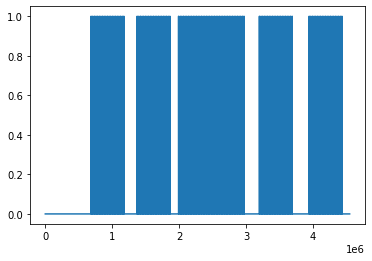

In [6]:
# Here we can access with ease the stimulation channel

plt.plot(thoracic.sync_data)

In [3]:
timestamps = processing.get_stim_timestamps(thoracic.sync_data) # here we get the timestamps of stimulation

avg_response_all_ch = {}
for ch in range(16):
    channel = "ch_" + str(ch)
    
    #here we parse the raw data according to the timestamps
    parsed_raw = processing.parse_raw(raw=thoracic.raw[ch], stimulation_idxs=timestamps, 
                                      samples_before_stim=0, skip_one=False)
    
    # here we average the signal according to how many amplitudes where tested
    avg_response = processing.get_average_amplitudes(parsed_raw, amplitudes_t)
    
    # adding the result to the dictionary of all channels
    avg_response_all_ch[channel] = [x[crop_artefact_out:crop_to_response] for x in avg_response]


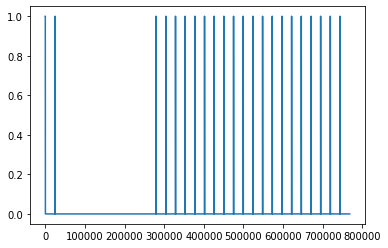

In [12]:
#Now we can parse the stimualtion channel according to the timestamps.

end_fifth_stim = timestamps[-23]
beginning_last_stim = timestamps[-1]
plt.plot(thoracic.sync_data[end_fifth_stim : beginning_last_stim])

In [4]:
# Computing the difference between the minimum point and the maximum, to display the radius proportional.

min_max = {}
for ch in range(16):
    channel = "ch_" + str(ch)
    amps = []
    for i in range(len(amplitudes_t)):
        cropped_chunk = avg_response_all_ch[channel][i]
        max_ = abs(np.max(cropped_chunk))
        max_idx = np.argmax(cropped_chunk)
        recropped = cropped_chunk[max_idx:]
        min_ = abs(np.min(recropped))
        amps.append(abs(max_+min_))
    min_max[channel] = amps


Text(0.5, 1.0, 'Thoracic stim: 600')

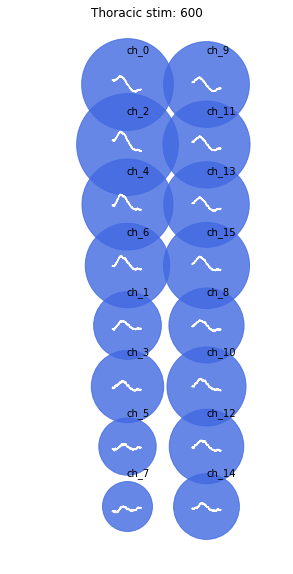

In [5]:
#Plotting only one amplitude

amp = 5
fig, ax = plt.subplots(figsize=(5,10))

for channel, coords in channel_mapping.items():
    x = [i-500 for i in range(coords[0]*crop_to_response*2, crop_to_response-crop_artefact_out+coords[0]*crop_to_response*2)]
    s = min_max[channel][amp] * 10**7.5
    ax.scatter(coords[0]*crop_to_response*2, coords[1], s=s, color="royalblue", alpha=0.8)
    ax.plot(x, avg_response_all_ch[channel][amp]*10**3+coords[1], color="w")
    ax.annotate(str(channel), (coords[0]*crop_to_response*2, coords[1]+0.5))
ax.set_xlim(-coords[0]*crop_to_response*3,coords[0]*crop_to_response*4)
ax.set_ylim(-1, 8)
ax.axis("off")
ax.set_title("Thoracic stim: " + str(amplitudes_t[amp]))